In [61]:
%matplotlib inline
import os
import json
import codecs
import numpy as np
import toolbox as tb
import matplotlib.pyplot as plt
import openquake.hazardlib.geo.geodetic as geo
import hmtk.sources as src
import hmtk.plotting.seismicity.catalogue_plots as cp

from string import Template
from collections import OrderedDict
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser
from hmtk.seismicity.selector import CatalogueSelector


In [62]:
# Marmaris, Turkey
target_lon = 28.25
target_lat = 36.85

# load fault data in JSON format
source_file = "Eastern_Mediterranean_Fault_Traces.geojson"
DATA = json.load(open(source_file, "r"))
DATA = OrderedDict([(dat["properties"]["IDSOURCE"], dat) 
                    for dat in DATA["features"]])

In [63]:
# the code provided is good for printing fault data but nothing else
def show_fault_properties(flt_id):
    fault = DATA[flt_id]
    # pretty print
    print "ID = %s" % fault["properties"]["IDSOURCE"]
    print "Name = %s" % fault["properties"]["SOURCENAME"]
    print "Trace (long. lat.):"
    for crd in fault["geometry"]["coordinates"]:
        print "    %.6f %.6f" % (crd[0], crd[1])
    print "Dip = %s - %s" % (str(fault["properties"]["DIPMIN"]), 
                             str(fault["properties"]["DIPMAX"]))
    print "Rake = %s - %s" % (str(fault["properties"]["RAKEMIN"]), 
                              str(fault["properties"]["RAKEMAX"]))
    print "Upper Seismogenic Depth = %s km" % \
        (str(fault["properties"]["MINDEPTH"]))
    print "Lower Seismogenic Depth = %s km" % \
        (str(fault["properties"]["MAXDEPTH"]))
    print "Slip Rate = %s - %s mm/yr" % \
        (str(fault["properties"]["SRMIN"]), 
         str(fault["properties"]["SRMAX"]))

In [64]:
show_fault_properties('TRCS394') # a fault of interest because it is nearby

ID = TRCS394
Name = Datca Horst North Boundary 1
Trace (long. lat.):
    27.653862 36.814250
    27.772547 36.818590
    27.891225 36.822930
    28.009910 36.827270
Dip = 60 - 60
Rake = 288 - 288
Upper Seismogenic Depth = 0.0 km
Lower Seismogenic Depth = 13.0 km
Slip Rate = 3.6056 - 7.2111 mm/yr


In [65]:
# loop over faults; compute and append statistics of interest
mu = 30e9 # [Pa] dummy value for estimate of moment rate
print "%d faults total" % len(DATA)
print "Adding some statistics ..."
for fault in DATA:
    fault_lonlat = np.array(DATA[fault]["geometry"]["coordinates"])
    min_depth = np.array(DATA[fault]["properties"]["MINDEPTH"])
    s_min = DATA[fault]["properties"]["SRMIN"]
    s_max = DATA[fault]["properties"]["SRMAX"]
    d_min = DATA[fault]["properties"]["MINDEPTH"]
    d_max = DATA[fault]["properties"]["MAXDEPTH"]
    phi_min = DATA[fault]["properties"]["DIPMIN"]
    phi_max = DATA[fault]["properties"]["DIPMAX"]
    
    L_max = geo.distance(fault_lonlat[0,0], fault_lonlat[0,1], 0, 
                    fault_lonlat[-1,0], fault_lonlat[-1,1], 0)
    R_all = geo.distance(target_lon, target_lat, 0, 
                    fault_lonlat[:,0], fault_lonlat[:,1], min_depth)
    R_min = np.min(R_all)
    R_max = np.max(R_all)
    R_mid = (R_max + R_min)/2
    W_max = (d_max - d_min)/np.abs(np.sin(phi_min))
    W_mid = (d_max - d_min)/np.abs(np.sin((phi_max + phi_min)/2))
    s_mid = (s_max + s_min)/2
    L_mid = L_max/2
    M0_rate_max = mu*L_max*1e3*W_max*1e3*s_max*1e-3
    M0_rate_mid = mu*L_mid*1e3*W_mid*1e3*s_mid*1e-3
    M0_rate_hybrid = mu*L_max*1e3*W_mid*1e3*s_mid*1e-3
    danger = M0_rate_hybrid/R_min
    
    DATA[fault]["statistics"] = {
        "R_min": R_min,
        "R_max": R_max,
        "R_mid": R_mid,
        "L_max": L_max,
        "W_max": W_max,
        "W_mid": W_mid,
        "s_mid": s_mid,
        "M0_rate_max": M0_rate_max,
        "M0_rate_mid": M0_rate_mid,
        "M0_rate_hybrid": M0_rate_mid,
        "danger": danger,
    }

925 faults total
Adding some statistics ...


In [66]:
# a function for filtering the fault list by "danger"
def pick_dangerous_faults(data, key, n, quiet=False):
    
    if key == 'R_min':
        reverse = False
    else:
        reverse = True
        
    data_sorted = sorted(data.items(), 
                key=lambda item: item[1]["statistics"][key], 
                                     reverse=reverse)

    top = OrderedDict(data_sorted[:n])

    if not quiet:
        print "  fault, R_min, L_max, W_mid, s_mid, M0_rate_hybrid, danger?"
    for (key, fault) in top.items():
        s_max = fault["properties"]["SRMAX"]

        R_min = fault["statistics"]["R_min"]
        L_max = fault["statistics"]["L_max"]
        W_mid = fault["statistics"]["W_mid"]
        s_mid = fault["statistics"]["s_mid"]
        M0_rate_max = fault["statistics"]["M0_rate_max"]
        M0_rate_mid = fault["statistics"]["M0_rate_mid"]
        M0_rate_hybrid = fault["statistics"]["M0_rate_hybrid"]
        danger = fault["statistics"]["danger"]

        if not quiet:
            print "%s, %5.1f, %5.1f, %5.1f, %5.1f, %7.1e, %7.1e"  % \
                (key, R_min, L_max, W_mid, s_mid, M0_rate_hybrid, danger)
        
    return top

In [67]:
template_file = "SimpleFaultTemplate.xml" 
with open(template_file, 'r') as myfile:
    template_string = myfile.read()
template_string

'<?xml version=\'1.0\' encoding=\'utf-8\'?>\n<nrml xmlns:gml="http://www.opengis.net/gml"\n      xmlns="http://openquake.org/xmlns/nrml/0.4">\n\n    <sourceModel name="$SOURCEMODELNAME">\n\n        <simpleFaultSource id="$IDSOURCE" name="$SOURCENAME" tectonicRegion="$REGION">\n            <simpleFaultGeometry>\n                <gml:LineString>\n                    <gml:posList>\n$TRACE\n                    </gml:posList>\n                </gml:LineString>\n                <dip>$DIP</dip>\n                <upperSeismoDepth>$MINDEPTH</upperSeismoDepth>\n                <lowerSeismoDepth>$MAXDEPTH</lowerSeismoDepth>\n            </simpleFaultGeometry>\n            <magScaleRel>$SCALEREL</magScaleRel>\n            <ruptAspectRatio>$ASPECTRATIO</ruptAspectRatio>\n            <$MFD/>\n            <rake>$RAKE</rake>\n        </simpleFaultSource>\n\n    </sourceModel>\n</nrml>\n'

In [68]:
def fault_json_to_xml(fault_json):

    fault_file_list = []
    region = "Active Shallow Crust"
    coord_format = "                        %10.6f %10.6f\n"
    scaling_relation = "WC1994"
    aspect_ratio = 2.0
    MFD = 'truncGutenbergRichterMFD aValue="4.0" bValue="1.0" minMag="5.0" maxMag="8.0"'

    for (key, fault) in fault_json.items():

        fault_lonlat = np.array(fault["geometry"]["coordinates"])
        coord_string = [(coord_format % tuple(coords)) for coords in fault_lonlat]
        coord_string = (''.join(coord_string))[:-1]
        dip_min = fault["properties"]["DIPMIN"]
        dip_max = fault["properties"]["DIPMAX"]
        rake_min = fault["properties"]["RAKEMIN"]
        rake_max = fault["properties"]["RAKEMAX"]

        with open(template_file, 'r') as myfile:
            template_string = myfile.read()

        template = Template(template_string)
        output_string = template.substitute(
            IDSOURCE=key,
            SOURCEMODELNAME="$SOURCEMODELNAME",
            SOURCENAME=fault["properties"]["SOURCENAME"],
            REGION=region,
            TRACE=coord_string,
            DIP="%.1f" % ((dip_min + dip_max)/2),
            MINDEPTH="%.1f" % fault["properties"]["MINDEPTH"],
            MAXDEPTH="%.1f" % fault["properties"]["MAXDEPTH"],
            SCALEREL=scaling_relation,
            ASPECTRATIO="%.3g" % aspect_ratio,
            MFD=MFD,
            RAKE="%.1f" % ((rake_min + rake_max)/2),
        )

        output_file = key + '.xml'

        with open(output_file, 'w') as myfile:
            myfile.write(output_string)

        fault_file_list.append(output_file)
                
    return fault_file_list

In [69]:
def concat_xml_faults(fault_xml_list, source_model_name, output_xml):
    
    joint_string = '\n    </sourceModel>\n' \
        + '</nrml>\n<?xml version=\'1.0\' encoding=\'utf-8\'?>\n' \
        + '<nrml xmlns:gml="http://www.opengis.net/gml"\n' \
        + '      xmlns="http://openquake.org/xmlns/nrml/0.4">\n\n' \
        + '    <sourceModel name="$SOURCEMODELNAME">\n'

    # read and concatenate all of the files
    faults = ''
    for file_name in fault_xml_list:
        with open(file_name, 'r') as myfile:
            fault = myfile.read()
        faults = faults + fault

    # remove redundent start/end XML 
    faults = faults.replace(joint_string,'')

    # give the model a name
    template = Template(faults)
    output_string = template.substitute(
        SOURCEMODELNAME=source_model_name)

    # ship it
    print "Writing results to ", output_xml
    with open(output_xml, 'w') as myfile:
        myfile.write(output_string)


In [70]:
# other faults to add
subduction_fault_file = "HellenicArc.xml"
n_faults = 20

In [71]:
# write "dangerous" source model
dangerous_sources_file = "MarmarisDangerousSources%d.xml" \
    % (n_faults + 1)
sources_name = "Top %d sources potentially dangerous to Marmaris" \
    % (n_faults + 1)

faults = pick_dangerous_faults(DATA, 'danger', n_faults, quiet=False)
fault_file_list = fault_json_to_xml(faults)
fault_file_list.append(subduction_fault_file)

concat_xml_faults(fault_file_list, sources_name, dangerous_sources_file)

  fault, R_min, L_max, W_mid, s_mid, M0_rate_hybrid, danger?
TRCS996, 424.5, 271.5,  74.9,  27.7, 8.4e+18, 4.0e+16
TRCS394,  21.5,  31.7,  42.6,   5.4, 1.1e+17, 1.0e+16
TRCS391,  22.3,  49.6,  15.7,   9.0, 1.1e+17, 9.4e+15
TRCS006, 623.1, 293.0,  26.6,  25.0, 2.9e+18, 9.4e+15
TRCS331, 115.5, 119.9,  49.5,   4.3, 3.8e+17, 6.7e+15
TRCS271,  77.2,  38.9,  57.2,   7.4, 2.5e+17, 6.4e+15
TRCS322, 156.8, 114.0,  49.5,   5.7, 4.8e+17, 6.2e+15
GRCS999, 426.4,  60.1,  51.1,  28.0, 1.3e+18, 6.0e+15
TRCS003, 773.1, 353.7,  18.3,  22.4, 2.2e+18, 5.6e+15
TRCS393,  48.0,  21.2,  42.6,   9.8, 1.3e+17, 5.5e+15
TRCS013, 438.1,  99.1,  27.8,  27.0, 1.1e+18, 5.1e+15
TRCS007, 498.7, 165.1,  20.7,  24.2, 1.2e+18, 5.0e+15
TRCS390, 239.7, 254.4,  38.9,   3.9, 5.8e+17, 4.9e+15
TRCS268,  85.2,  36.3,  49.5,   7.4, 2.0e+17, 4.7e+15
GRCS603, 706.0, 116.5,  68.9,  12.5, 1.5e+18, 4.3e+15
TRCS913,  20.5,  84.2,  19.6,   1.8, 4.3e+16, 4.2e+15
TRCS023, 396.7,  95.0, 102.2,   5.3, 7.8e+17, 3.9e+15
TRCS001, 1111.8,  51.

In [72]:
# write "nearby" source model
nearby_sources_file = "MarmarisNearbySources%d.xml" \
    % (n_faults + 1)
sources_name = "Top %d sources nearest to Marmaris.xml" \
    % (n_faults + 1)

faults = pick_dangerous_faults(DATA, 'R_min', n_faults, quiet=False)
fault_file_list = fault_json_to_xml(faults)
fault_file_list.append(subduction_fault_file)

concat_xml_faults(fault_file_list, sources_name, nearby_sources_file)

  fault, R_min, L_max, W_mid, s_mid, M0_rate_hybrid, danger?
TRCS913,  20.5,  84.2,  19.6,   1.8, 4.3e+16, 4.2e+15
TRCS394,  21.5,  31.7,  42.6,   5.4, 1.1e+17, 1.0e+16
TRCS391,  22.3,  49.6,  15.7,   9.0, 1.1e+17, 9.4e+15
TRCS396,  37.8,  51.9,  13.1,   5.5, 5.6e+16, 3.0e+15
TRCS413,  39.4,  31.2,  13.1,   1.0, 6.3e+15, 3.2e+14
TRCS414,  40.7,  15.9,  13.1,   1.0, 3.2e+15, 1.6e+14
TRCS392,  42.6,  16.4,  16.8,   4.9, 2.0e+16, 9.5e+14
TRCS412,  47.2,  11.5,  13.1,   1.0, 2.3e+15, 9.9e+13
TRCS393,  48.0,  21.2,  42.6,   9.8, 1.3e+17, 5.5e+15
TRCS397,  49.9,  22.0,  13.1,   1.0, 4.4e+15, 1.8e+14
TRCS415,  58.1,  38.6,  13.1,   1.0, 7.8e+15, 2.7e+14
TRCS398,  58.4,  10.1,  13.1,   1.0, 2.1e+15, 7.0e+13
TRCS395,  63.3,  12.3,  42.6,   5.4, 4.2e+16, 1.3e+15
TRCS338,  69.7,  17.1,  39.4,   5.8, 5.9e+16, 1.7e+15
TRCS271,  77.2,  38.9,  57.2,   7.4, 2.5e+17, 6.4e+15
GRCS965,  77.6,  44.2,  19.6,   3.0, 3.9e+16, 1.0e+15
TRCS293,  79.0,  22.9,  53.4,   1.3, 2.4e+16, 6.1e+14
TRCS268,  85.2,  36.3

In [73]:
catalogue_filename = '../seismicity/output_homogenized_Marmaris.csv'
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file() 

print 'Minimum magnitude: ', np.min(catalogue.data['magnitude'])
print 'Maximum magnitude: ', np.max(catalogue.data['magnitude'])
print 'Number of events: ', len(catalogue.data['magnitude'])
print 'Catalogue keys: '
print catalogue.data.keys()

Catalogue Attribute Identifier is not a recognised catalogue key
Minimum magnitude:  0.75
Maximum magnitude:  7.6
Number of events:  30006
Catalogue keys: 
['eventID', 'comment', 'sigmaMagnitude', 'hour', 'SemiMinor90', 'magnitude', 'Agency', 'second', 'longitude', 'month', 'depthError', 'flag', 'depth', 'magnitudeType', 'SemiMajor90', 'timeError', 'year', 'latitude', 'ErrorStrike', 'day', 'minute']


(10, 100000.0)

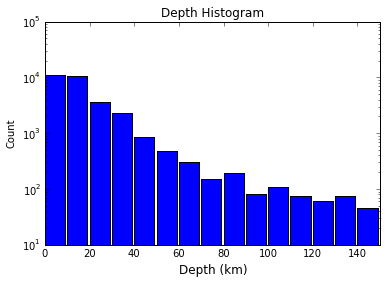

In [74]:
bin_width = 10
normalisation=False
bootstrap=None
depth_bins = np.arange(0.,
                       np.max(catalogue.data['depth']) + bin_width,
                       bin_width)

depth_hist = catalogue.get_depth_distribution(depth_bins,
                                          normalisation=normalisation,
                                          bootstrap=bootstrap)
plt.bar(depth_bins[:-1],
        depth_hist,
        width=0.9*bin_width,
        edgecolor='k')
plt.xlabel('Depth (km)', fontsize='large')
if normalisation:
    plt.ylabel('Probability Mass Function', fontsize='large')
else:
    plt.ylabel('Count')
plt.title('Depth Histogram', fontsize='large')
plt.yscale('log')

plt.xlim((0,150))
plt.yscale('log')
plt.ylim((10,1e5))

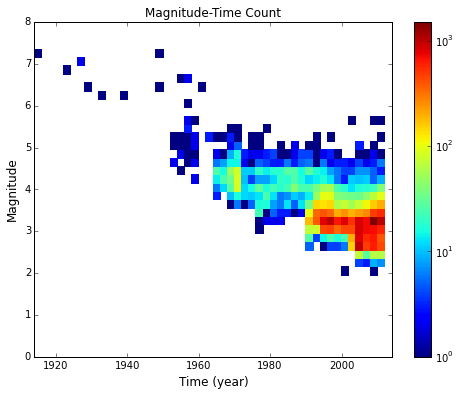

In [75]:
cp.plot_magnitude_time_density(catalogue, 0.2, 2)

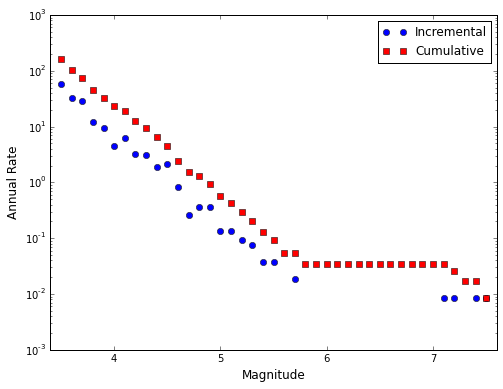

In [76]:
completeness_table_a = np.array([[1992, 3.5],
                                 [1978, 4.0], 
                                 [1963, 5.0],
                                 [1900, 7.0]]) 
cp.plot_observed_recurrence(catalogue, completeness_table_a, 0.1)

In [77]:
# Map configuration
span = 1 # deg
map_config = {"min_lon": target_lon - 2*span, 
              "max_lon": target_lon + 2*span, 
              "min_lat": target_lat - span, 
              "max_lat": target_lat + span, "resolution": "l"}

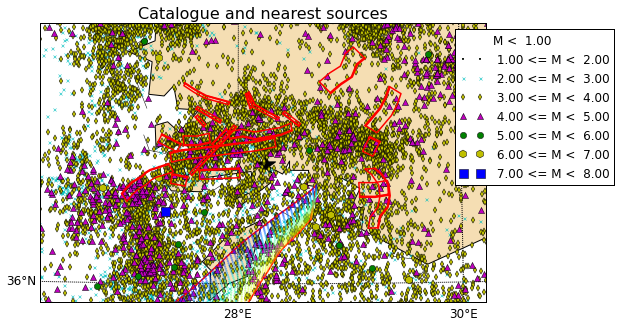

In [78]:
# Creating a basemap 
basemap1 = HMTKBaseMap(map_config, 'Catalogue and nearest sources')

# Adding the catalogue to the basemap
basemap1.add_catalogue(catalogue, overlay=True)

# Reading the models 
parser = nrmlSourceModelParser(nearby_sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

# Adding the seismic sources
basemap1.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5, overlay=True)

# Add target
basemap1.add_size_scaled_points(target_lon, target_lat, 20, shape='*', 
                                colour='k', zorder=6)

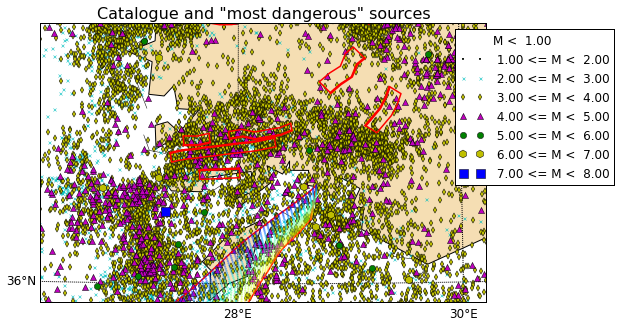

In [79]:
# Creating a basemap 
basemap1 = HMTKBaseMap(map_config, 'Catalogue and "most dangerous" sources')

# Adding the catalogue to the basemap
basemap1.add_catalogue(catalogue, overlay=True)

# Reading the models 
parser = nrmlSourceModelParser(dangerous_sources_file)

# Parse the seismic sources and save them in "source_model"
source_model = parser.read_file("Sources Around Marmaris")

# Adding the seismic sources
basemap1.add_source_model(source_model, area_border='r-', 
                          border_width=1.5, alpha=0.5) 